In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
# Load Data
data = pd.read_csv("Tweets.csv",index_col="tweet_id")
data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
data.shape

(14640, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 570306133677760513 to 569587140490866689
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   negativereason                9178 non-null   object 
 3   negativereason_confidence     10522 non-null  float64
 4   airline                       14640 non-null  object 
 5   airline_sentiment_gold        40 non-null     object 
 6   name                          14640 non-null  object 
 7   negativereason_gold           32 non-null     object 
 8   retweet_count                 14640 non-null  int64  
 9   text                          14640 non-null  object 
 10  tweet_coord                   1019 non-null   object 
 11  tweet_created                 14640 non-null  object 
 12  tweet_location                

In [5]:
data.nunique()

airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [6]:
data.isnull().sum()

airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

# EDA

In [7]:
count = data["airline_sentiment"].value_counts()
pd.DataFrame(count)

,airline_sentiment
negative,9178
neutral,3099
positive,2363


Text(0.5, 1.0, 'Number of Tweets per Class')

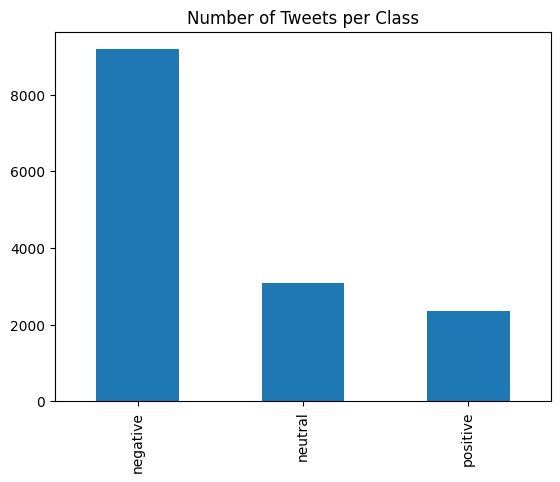

In [8]:
count.plot(kind = "bar")
plt.title('Number of Tweets per Class')

In [9]:
group = data.groupby(["airline", "airline_sentiment"]).size()
pd.DataFrame(group)

0
airline        airline_sentiment      
American       negative           1960
               neutral             463
               positive            336
Delta          negative            955
               neutral             723
               positive            544
Southwest      negative           1186
               neutral             664
               positive            570
US Airways     negative           2263
               neutral             381
               positive            269
United         negative           2633
               neutral             697
               positive            492
Virgin America negative            181
               neutral             171
               positive            152

Text(0.5, 1.0, 'Airline Sentiment by Airline')

<Figure size 1000x800 with 0 Axes>

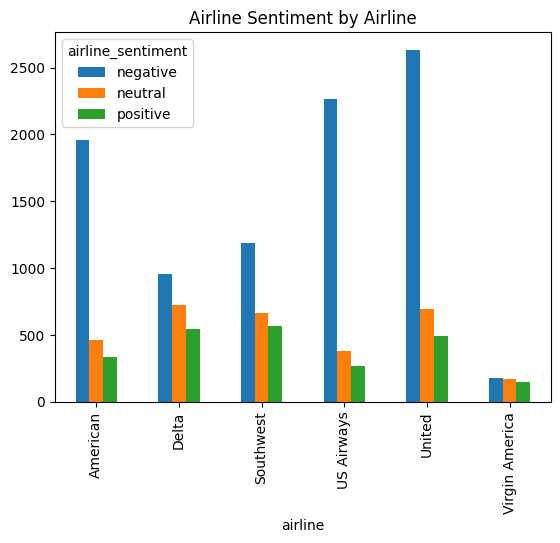

In [84]:
plt.figure(figsize=(10,8))
group.unstack().plot(kind = "bar")
plt.title('Airline Sentiment by Airline')

In [101]:
neg_value = data["negativereason"].value_counts()
neg_value

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

Text(0.5, 1.0, 'Negative Reasons for Tweets')

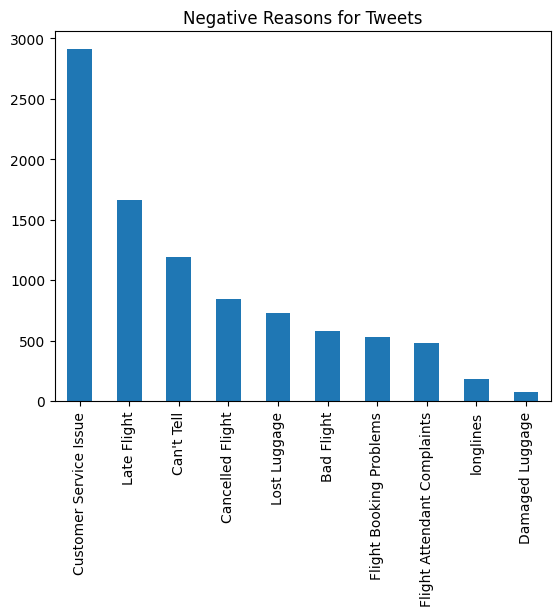

In [12]:
neg_value.plot(kind = "bar")
plt.title('Negative Reasons for Tweets')

# Data Pre-processing 

In [13]:
# Changing object to date-time format
data["tweet_created"] = pd.to_datetime(data["tweet_created"]).dt.date
data["tweet_created"] = pd.to_datetime(data["tweet_created"])

In [14]:
data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,NaN,Pacific Time (US & Canada)


In [15]:
no_of_tweet = data.groupby("tweet_created").size()
no_of_tweet

tweet_created
2015-02-16       4
2015-02-17    1408
2015-02-18    1344
2015-02-19    1376
2015-02-20    1500
2015-02-21    1557
2015-02-22    3079
2015-02-23    3028
2015-02-24    1344
dtype: int64

In [16]:
data.isnull().sum()

airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [17]:
data.shape

(14640, 14)

In [18]:
# del column with more than 90% data missing
del data["tweet_coord"]
del data["airline_sentiment_gold"]
del data["negativereason_gold"]
data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada)


In [106]:
neg_reason = data.groupby("negativereason").size()
neg_reason

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
dtype: int64

In [52]:
total_tweets = data.groupby(['airline'])['airline_sentiment'].count()

In [87]:
my_dict = {'American':group[0] / total_tweets[0],'Delta':group[3] / total_tweets[1],'Southwest': group[6] / total_tweets[2],
'US Airways': group[9] / total_tweets[3],'United': group[12] / total_tweets[4],'Virgin': group[15] / total_tweets[5]}

perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ["Negative Percent"]
print(perc)

            Negative Percent
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


<AxesSubplot: >

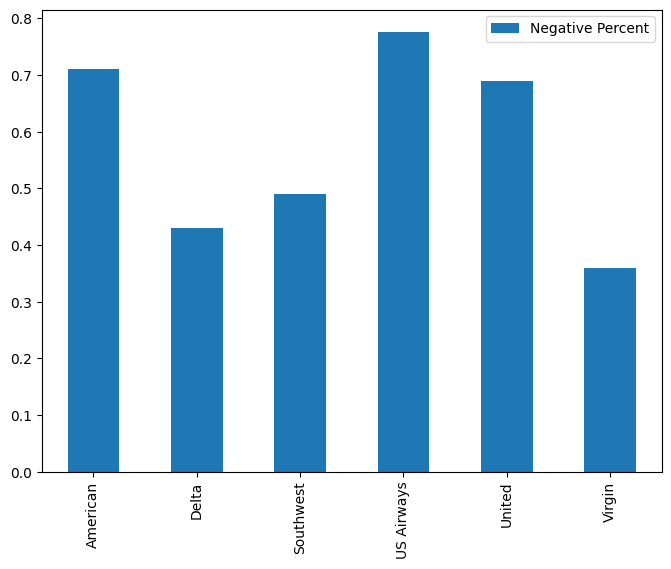

In [75]:
perc.plot(kind="bar", figsize=(8,6))

In [108]:
negative_reasons = data.groupby("airline")["negativereason"].value_counts(ascending=True)

Text(0.5, 1.0, 'The number of the count of negative reasons for airlines')

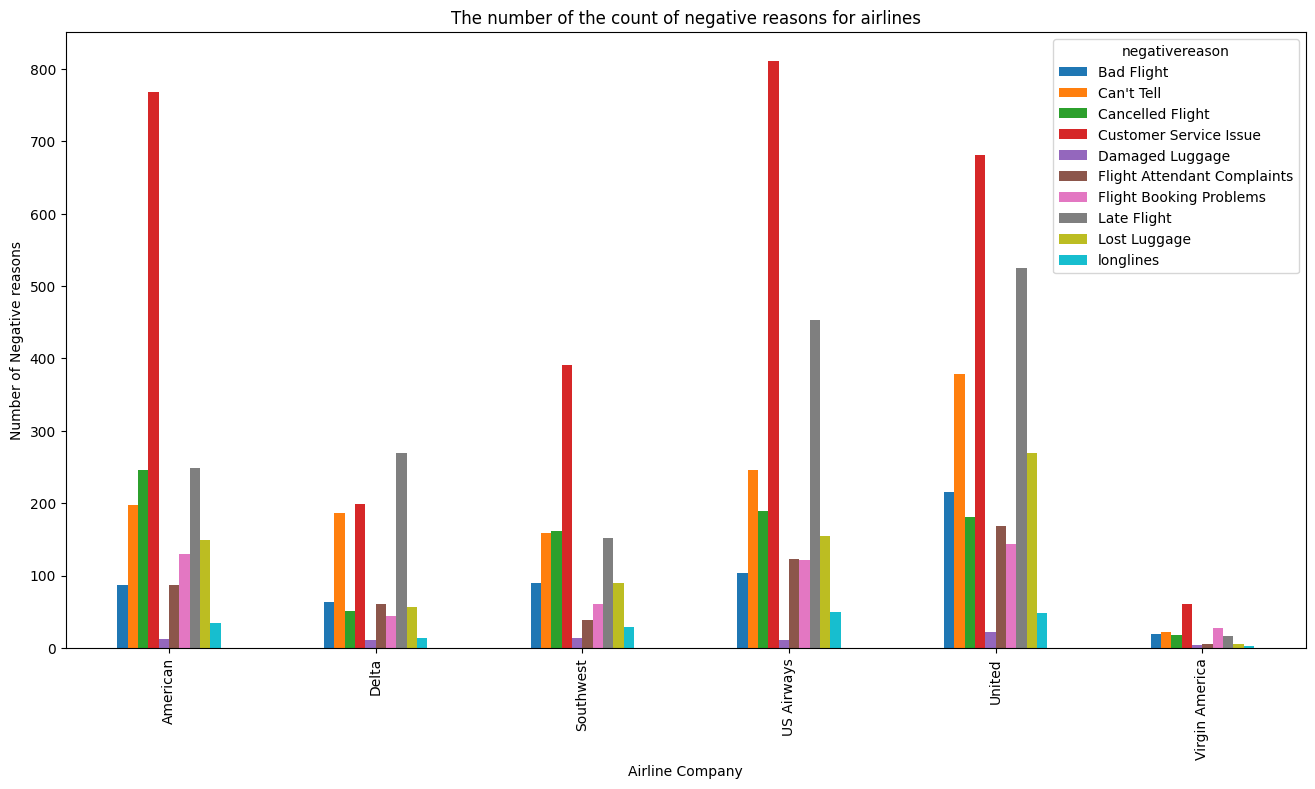

In [121]:
# 10 reason for their complain
negative_reasons.unstack().plot(kind="bar",figsize=(16,8))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")

In [159]:
# checking relationship between negative sentiments and date?
df = data.reset_index()
#convert the Date column to pandas datetime
df.tweet_created = pd.to_datetime(df.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
df.tweet_created = df.tweet_created.dt.date
df.tweet_created.head()

0    2015-02-24
1    2015-02-24
2    2015-02-24
3    2015-02-24
4    2015-02-24
Name: tweet_created, dtype: object

In [160]:
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

In [161]:
day_df = day_df.loc[:,:,'negative']
day_df

tweet_created  airline       
2015-02-16     Delta               1
               United              2
2015-02-17     Delta             108
               Southwest         213
               US Airways        233
               United            272
               Virgin America     12
2015-02-18     American            1
               Delta             105
               Southwest         110
               US Airways        244
               United            257
               Virgin America     19
2015-02-19     Delta             135
               Southwest         127
               US Airways        193
               United            272
               Virgin America     24
2015-02-20     American            1
               Delta              91
               Southwest         132
               US Airways        248
               United            342
               Virgin America     21
2015-02-21     American            1
               Delta              98
        

Text(0, 0.5, 'Negative Tweets')

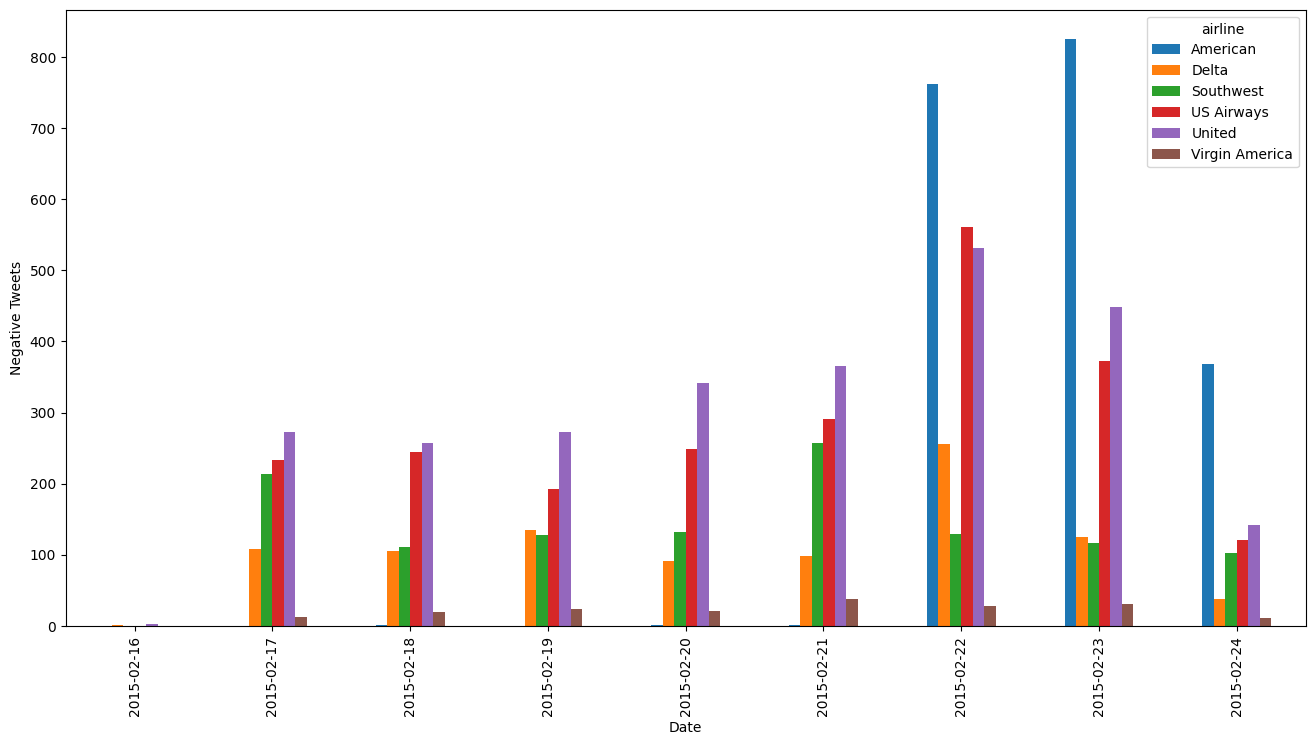

In [164]:
day_df.unstack().plot(kind="bar", figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Negative Tweets')

In [175]:
# Droping neutral row sentiments
data.drop(data.loc[data["airline_sentiment"] == "neutral"].index, inplace=True)

In [177]:
# label encoding on airline sentiment
le = LabelEncoder()
le.fit(data["airline_sentiment"])

LabelEncoder()

In [178]:
data["airline_sentiment_encoded"] = le.transform(data["airline_sentiment"])
data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,airline_sentiment_encoded
tweet_id,,,,,,,,,,,,
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada),1
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada),0
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada),0
570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24,NaN,Pacific Time (US & Canada),0
570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24,San Francisco CA,Pacific Time (US & Canada),1


In [192]:
# preprocess the tweet text data
def tweet_to_word(tweet):
    letter_only = re.sub("[^a-zA-Z]"," ",tweet)
    words = letter_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join(meaningful_words ))

In [193]:
data["clean_tweet"] = data["text"].apply(lambda x:tweet_to_word(x))
data["clean_tweet"]

tweet_id
570301130888122368    virginamerica plus added commercials experienc...
570301031407624196    virginamerica really aggressive blast obnoxiou...
570300817074462722                   virginamerica really big bad thing
570300767074181121    virginamerica seriously would pay flight seats...
570300616901320704    virginamerica yes nearly every time fly vx ear...
                                            ...                        
569587705937600512    americanair flight cancelled flightled leaving...
569587691626622976                         americanair right cue delays
569587686496825344       americanair thank got different flight chicago
569587371693355008    americanair leaving minutes late flight warnin...
569587188687634433    americanair money change flight answer phones ...
Name: clean_tweet, Length: 11527, dtype: object

In [198]:
# Vectorization

X = data.clean_tweet
y = data.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

In [200]:
vec = CountVectorizer()
vec.fit(X_train)

CountVectorizer()

In [201]:
X_train_dt = vec.transform(X_train)
X_test_dt = vec.transform(X_test)

In [204]:
vec_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vec_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

In [206]:
# Build Model
model = SVC(kernel="linear", random_state=40)
model.fit(X_train_dt, y_train)

SVC(kernel='linear', random_state=40)

In [208]:
y_pred = model.predict(X_test_dt)
y_pred

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [217]:
accuracy_score(y_test, y_pred)

0.9087439278278973

In [210]:
confusion_matrix(y_test, y_pred)

array([[2147,  125],
       [ 138,  472]], dtype=int64)

In [212]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      2272
    positive       0.79      0.77      0.78       610

    accuracy                           0.91      2882
   macro avg       0.87      0.86      0.86      2882
weighted avg       0.91      0.91      0.91      2882



`SVM gives the accuracy score of 91% according to classification report`